## Pytorch Workflow
 Below is the end-to-end workflow we use when working with Pytorch.

 1. Data preparation and loading
 2. Build a Model
 3. Fitting a model to data aka Training the Model
 4. Making predictions and Evaluating a model
 5. Saving and loading a model
 6. Putting it all together

In [76]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.4.1+cu121'

## 1. Data preparation and loading
Data can be anything in ML
* CSV
* Img
* Video
* Text, etc

In simple terms ML does 2 things
1. Get data in numerical format
2. Build a model to learn patterns in that format

In [77]:
# Creating a regressing example with known parameter(weight and bias)
start = 0
end = 1
step = 0.02

wht= 0.7
bias=0.3
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = wht * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [78]:
# Splitting data in train-validate-test set with ratio of 60-20-20
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [79]:
# Vizualing the data
def plot_preds(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
  """
  Plots training data, test data and compares predictions
  """
  plt.figure(figsize=(10,7))
  #Plot training data
  plt.scatter(train_data, train_labels, c="#00b4c5",  s=4, label="Training Data")

  #PLot test data
  plt.scatter(X_test, y_test, c="#fc82cf", s=4, label="Test Data")

  #Are there prediction?
  if predictions is not None:
    plt.scatter(test_data,predictions, c="#f57600", s=4, label="Predictions")

  plt.legend(prop={"size":12})

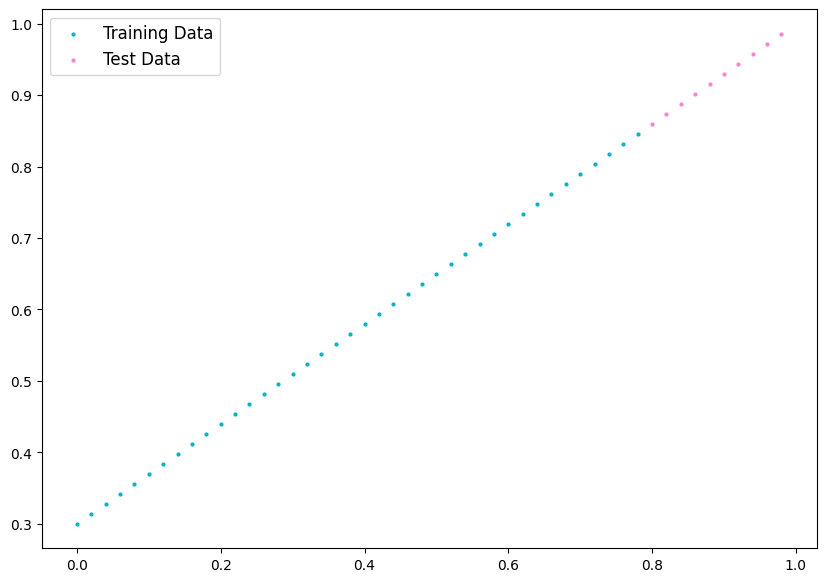

In [80]:
plot_preds()

## 2. Build Model
What our model do
* Start with random values (weight and biases)
* Look at training data and adjust the random values to better represent the ideal values.

So how do we do it?
we use 2 main algo
1. Gradient descent
2. Backpropogation

## PyTorch Model building essentials


* Torch.nn - contains all of the bulding block for computational graphs(neural networks are a computatinal graphs)
* torch.nn.Parameter - what parameters should our model try and learn often a PyTorch layer from torch.nn will set these for us.
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward().
* torch.optim - This is where the pytorch optimizers live, optimizers help with gradient descent and backpropogation.
* def forward() - All nn.Module subclasses need to overwrite this method, to define the computation that our model needs to perform.



In [81]:
# Create linear regression model

# Everything in pytorch inherits nn.Module
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))

    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=float))
  # Forward method to define computation in model
  def forward(self, x:torch.Tensor) -> torch.Tensor:# x > is input
    return self.weights * x + self.bias # linear regression formula

## Checking the content of Pytorch model
TO do this we use modelObj.parameters()

In [82]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (i.e our subclass of nn.Module)
model = LinearRegressionModel()

#Checking the parameter
list(model.parameters()) # Gives raw o/p of model parameters
model.state_dict() # To get the proper names of our parameters

OrderedDict([('weights', tensor([0.3367])),
             ('bias', tensor([0.1288], dtype=torch.float64))])

### Making prediction using `torch.inference_mode()`

To check our models predictive power, we'll pass our data through our model's forward method.


In [83]:
# Make predictions with model(Recommended)
with torch.inference_mode():
  y_preds = model(X_test)
y_preds

# Other older way of above is
# with torch.no_grad():
#   y_preds = model(X_test)
# y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], dtype=torch.float64)

torch.inference_mode() is a context manager. It basically runs model without grad function or gradient tracking, and by this we save up memory and time during training phase. Since maintaing gradients is expensive process and only need at time actual predictions

In [84]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

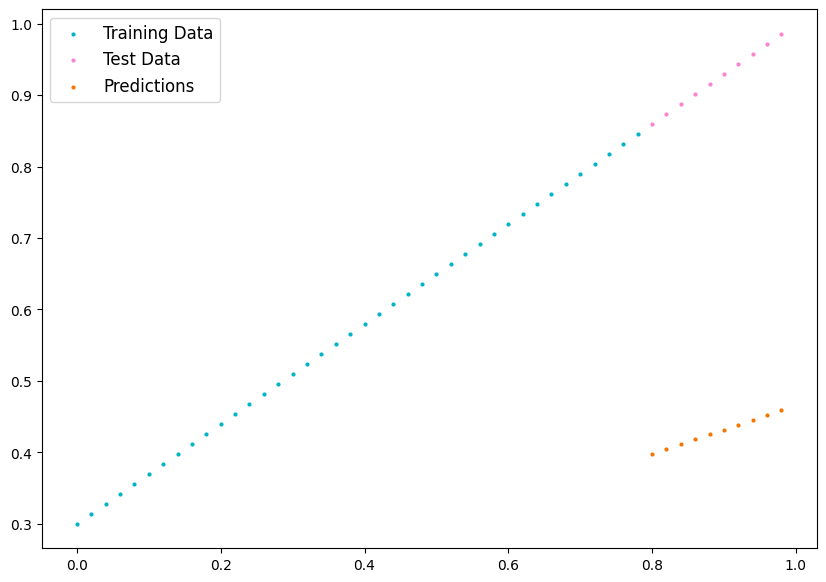

In [85]:
plot_preds(predictions=y_preds)

## 3. Train the model
 The whole idea of training model, is for model to move from some unknown parameters to some know ideal values, i.e from poor to better representation of data.

__To better the performance__ we use:
1. Loss Function: A function to measure; how wrong our model predictions are to the ideal o/p. Lower the loss, better the performance

2. Optimizer: Takes into account the loss of the model and adjust the models parameters.


In [86]:
# Setup a loss function
loss_fcn = nn.L1Loss() # L1Loss = Mean absolute error

# Setup an optimizer
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.015) #lr is learning rate; its most imp hyper-parameter. the value decides how much of a change optimizer will make to model parameters(weights, biases)s

### Building a training and testing loop in PyTorch

Our loop setup involves following:
0. Loop through the data
1. Forward Pass: moving data from our models `forward()` function to make predeiction aka forward propogation/pass
2. Calculate Loss: Compare the forward pass values with ground truth labels
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each parameter of our model w.r.t the loss (aka __Backpropogation__)
5. Optimizing step - use optimizer function(SGD,Adam,etc) to adjust models parameters to reduce the loss.

In [87]:
list(model.parameters()), model.state_dict()

([Parameter containing:
  tensor([0.3367], requires_grad=True),
  Parameter containing:
  tensor([0.1288], dtype=torch.float64, requires_grad=True)],
 OrderedDict([('weights', tensor([0.3367])),
              ('bias', tensor([0.1288], dtype=torch.float64))]))

In [88]:
# Setup the training loop
torch.manual_seed(42)
# epoch: is a one loop through data.

# Track different values
epochs = 100
epoch_count = []
loss_values = []
test_loss_values = []

### Training loop:

# 0. Loop through the data
for epoch in range(epochs):
  # set model in training mode
  model.train() # Put model in train mode, i.e all model parameter will have
  #requires_gradient=True

  #1. Forward pass
  y_pred = model(X_train)

  #2. Calculate loss
  loss = loss_fcn(y_pred, y_train)

  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Perform backpropogation on the loss with respect to the parameters of the model
  loss.backward()

  #5. Step the optimizer (perform gradient descent)
  optimizer.step()
  # by default optimizer will accumilate each loops model gradients, so
  #to reset it to zero we do 3

  ### Testing
  model.eval()
  # turns off various settings in the model not needed for evaluation(dropout, batchnorm layers, etc)
  with torch.inference_mode():
    #1. Do forward pass
    test_preds = model(X_test)

    #2. Calculate loss
    test_loss = loss_fcn(test_preds, y_test)

    #Printing progress after each 10 epochs
    if epoch % 10 == 0:
      epoch_count.append(epoch)
      loss_values.append(loss)
      test_loss_values.append(test_loss)
      print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
      print(model.state_dict())

Epoch: 0 | Loss: 0.3128813517678373 | Test Loss: 0.47432968599748165
OrderedDict([('weights', tensor([0.3425])), ('bias', tensor([0.1438], dtype=torch.float64))])
Epoch: 10 | Loss: 0.1400664020611747 | Test Loss: 0.2722647963280632
OrderedDict([('weights', tensor([0.4010])), ('bias', tensor([0.2938], dtype=torch.float64))])
Epoch: 20 | Loss: 0.05280924969041405 | Test Loss: 0.14172428197812575
OrderedDict([('weights', tensor([0.4525])), ('bias', tensor([0.3786], dtype=torch.float64))])
Epoch: 30 | Loss: 0.043481139935539884 | Test Loss: 0.10413104946565173
OrderedDict([('weights', tensor([0.4855])), ('bias', tensor([0.3868], dtype=torch.float64))])
Epoch: 40 | Loss: 0.03825408712958145 | Test Loss: 0.08863145656537541
OrderedDict([('weights', tensor([0.5121])), ('bias', tensor([0.3786], dtype=torch.float64))])
Epoch: 50 | Loss: 0.03310716216823632 | Test Loss: 0.07622294182729225
OrderedDict([('weights', tensor([0.5379])), ('bias', tensor([0.3681], dtype=torch.float64))])
Epoch: 60 | L

In [89]:
with torch.inference_mode():
  y_pred_new = model(X_test)

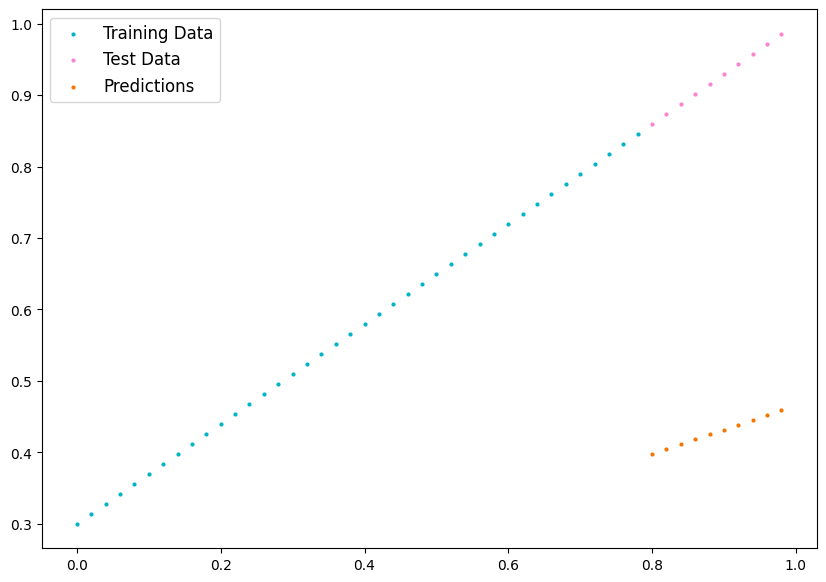

In [90]:
plot_preds(predictions=y_preds) #old preds,

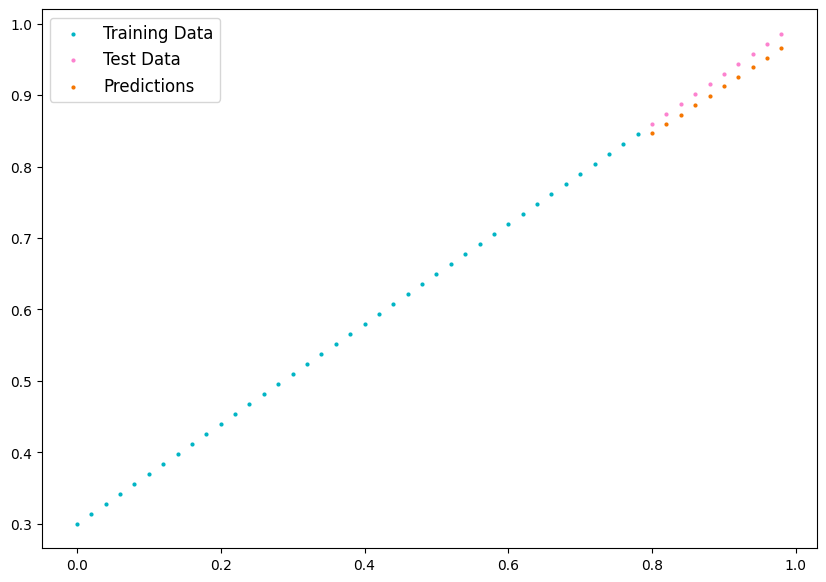

In [91]:
plot_preds(predictions=y_pred_new) #new preds after training loop

In [92]:
wht,bias, model.state_dict()

(0.7,
 0.3,
 OrderedDict([('weights', tensor([0.6636])),
              ('bias', tensor([0.3156], dtype=torch.float64))]))

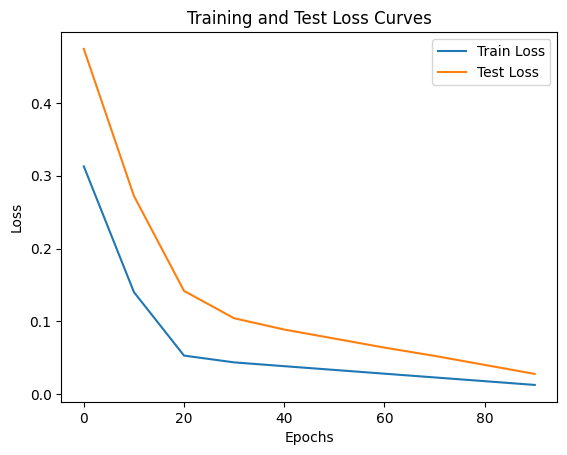

In [93]:
#Plotting the Loss curves
plt.plot(epoch_count, torch.tensor(loss_values).numpy(), label="Train Loss")
plt.plot(epoch_count, torch.tensor(test_loss_values).numpy(), label="Test Loss")
plt.title("Training and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

## Saving and Loading the model in PyTorch

There are 3 main methods for saving and loading the model with pytorch

1. `torch.save()`: save model as pytorch object in pickel format.
2. `torch.load()`: load the saved pytorch model.
3. `torch.nn.Module.load_state_dict()`: loads the models state dictonary

In [95]:
# Saving pytorch models
from pathlib import Path

#1. Create model dir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving model to: {MODEL_SAVE_PATH}")

#3. Save the model state dict
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model.pth


## Loading models state dict

We save only state dict altohough we can save entier model but that take more time and space, wehere as knowing only the right parameters and model type we can create new instance quickly

In [96]:
model.state_dict()

OrderedDict([('weights', tensor([0.6636])),
             ('bias', tensor([0.3156], dtype=torch.float64))])

In [97]:
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-97-3287f0af3ffc>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [98]:
loaded_model.state_dict()

OrderedDict([('weights', tensor([0.6636])),
             ('bias', tensor([0.3156], dtype=torch.float64))])